Kaggle data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

We are challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

The dataset comprises of comments from Wikipedia’s talk page edits.

For each id in the test set, you must predict a probability for each of the six possible types of comment toxicity: 
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate)



## Import relevant libraries and load the data

In [1]:
# !pip install nltk

import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form
# from nltk.chunk import ne_chunk  # Named Entity recognition
# from nltk.tag import pos_tag  # Helps to recognize whether the word is a noun, adj, etc.
# from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# nltk.download()

import pandas as pd

### Load the CSV and take a peek at 1st 5 rows

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### Let's see how the comments look like

In [4]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [6]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

### Exploratory Data Analysis

In [7]:
# There are 159,571 reviews in the dataset
len(data)

159571

In [8]:
# Check percentage of comments that are toxic compared to normal comments
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

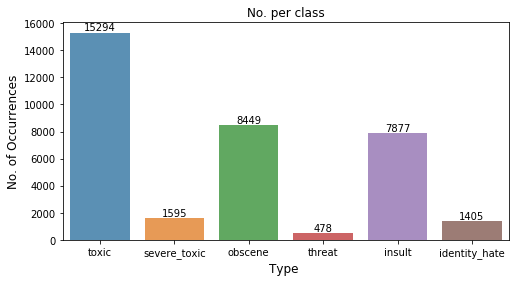

In [9]:
''' 
Modified from Kaggle notebooks. Create graph of count of comments of various toxic categories
'''

#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category
ax= sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

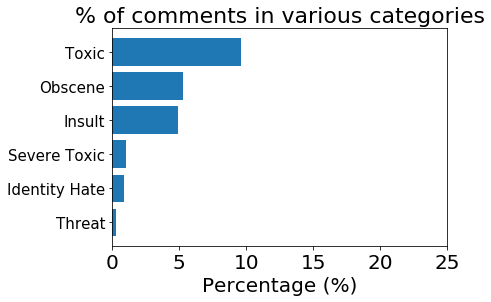

In [10]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / 159571 * 100
sum_sev = data['severe_toxic'].sum() / 159571 * 100
sum_obs = data['obscene'].sum() / 159571 * 100
sum_thr = data['threat'].sum() / 159571 * 100
sum_ins = data['insult'].sum() / 159571 * 100
sum_ide = data['identity_hate'].sum() / 159571 * 100

ind = np.arange(6)
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])

plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)
plt.gca().invert_yaxis()
plt.show()

### Check for missing values

In [11]:
data.isnull().values.any()


False

Seems like there's no missing values

### Preprocess the text

In [12]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

### Separate our dataset into 6 sections. Each section is comment + 1 category.

In [13]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [14]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [15]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [16]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [17]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [18]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

### Creating WordCloud

In [19]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [20]:
def wordcloud(df, label):
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

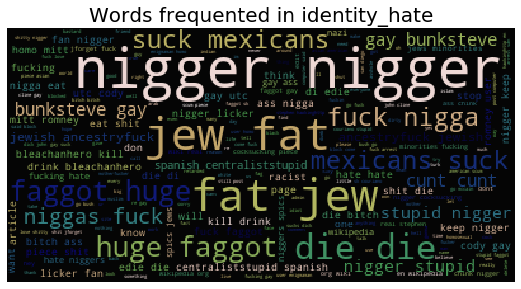

In [21]:
wordcloud(data_ide,'identity_hate')

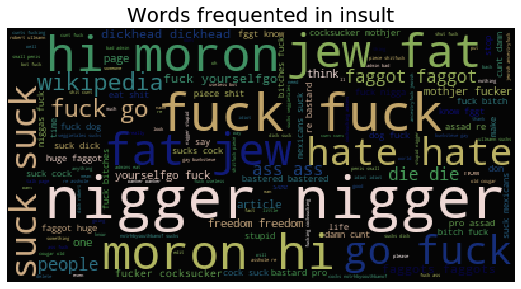

In [22]:
wordcloud(data_ins, 'insult')

### Take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have balanced data.

In [23]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [24]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [25]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [26]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [27]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

In [28]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [29]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [30]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [31]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [32]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [33]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [34]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [35]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Number of Comment that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [36]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import LR, KNN, NB, SVM, DT, RF, XGB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


### Create simple function that takes in a dataset and allows user to choose target category, vectorizer and number of ngrams

In [ ]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):

# vectorizer values: CountVectorizer, TfidfVectorizer
# ngram_range values: (1,1) for unigram, (2,2) for bigram

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [38]:
# def cv_tf_train_test(df_done,label,vectorizer,ngram)

# vectorizer values: CountVectorizer, TfidfVectorizer
# ngram_range values: (1,1) for unigram, (2,2) for bigram

import time

t0 = time.time()
df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_tox_cv

# cv_tf_train_test(data_tox_done, 'toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', CountVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', CountVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', CountVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', CountVectorizer, (1,1))

# cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))


C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 18.9216628074646 seconds


,F1 Score(toxic)
Log Regression,0.861234
KNN,0.198837
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876133
Random Forest,0.838055


In [39]:
import time

t0 = time.time()
df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 2.959498643875122 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.856046
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.934874


In [40]:
import time

t0 = time.time()
df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_obs_cv

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 17.10419225692749 seconds


,F1 Score(obscene)
Log Regression,0.908655
KNN,0.511339
BernoulliNB,0.787830
MultinomialNB,0.901463
SVM,0.921378
Random Forest,0.909091


In [41]:
import time

t0 = time.time()
df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_thr_cv

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 1.9100120067596436 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.795539


In [42]:
import time

t0 = time.time()
df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_ins_cv

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 18.080021619796753 seconds


,F1 Score(insult)
Log Regression,0.896599
KNN,0.262332
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.883993


In [43]:
import time

t0 = time.time()
df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_ide_cv

C:\Users\Edward\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done
Time taken: 9.512994527816772 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.219561
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.768448


In [44]:
# Calculate average F1 score
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.861234,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.198837,0.856046,0.511339,0.262332,0.720000,0.219561
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901463,0.897411,0.504762,0.485857
SVM,0.876133,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.838055,0.934874,0.909091,0.883993,0.795539,0.768448


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [45]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.861234,0.198837,0.776521,0.874958,0.876133,0.838055
F1 Score(severe_toxic),0.927879,0.856046,0.803707,0.936170,0.926004,0.934874
F1 Score(obscene),0.908655,0.511339,0.787830,0.901463,0.921378,0.909091
F1 Score(insult),0.896599,0.262332,0.783762,0.897411,0.902619,0.883993
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score(identity_hate),0.699029,0.219561,0.549206,0.485857,0.797516,0.768448


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

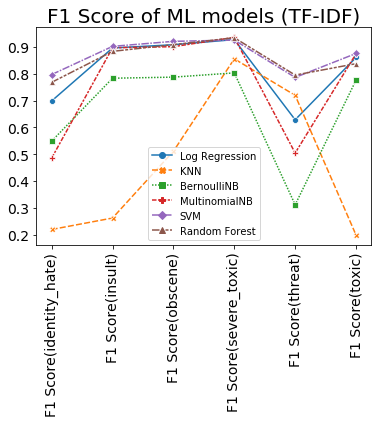

In [46]:
sns.lineplot(data=f1_all_trp, size=[10,10], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# Repeat this for CountVectorizer as well

LinearSVC and Random Forest models perform best.

### Test if our code actually works. Probability of the comment falling in various categories should be output

In [ ]:
data_tox_done.head()

In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



In [ ]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

## Pickling trained RandomForest models for all categories, since RDF has predict_proba function

In [47]:
import pickle

In [ ]:
data_tox_done.head()

### We have to pickle not only the TF-IDF vectorizer object, but also the RDF model trained on the related vectorizer

In [ ]:
# Pickle the TF-IDF Vocabulary
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    X_vect = tfv.fit_transform(X)  # Convert the X data into a document term matrix dataframe
    
    with open(r"C:\Users\Edward\OneDrive\METIS files from Gigabyte laptop\METIS Project 4\Flask app for toxic comments\{}.pkl".format(label + '_vect'), "wb") as f:   # wb means Writing to the file in Binary mode, written in byte objects
        pickle.dump(tfv, f)   # saves the column labels (ie the vocabulary)
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"C:\Users\Edward\OneDrive\METIS files from Gigabyte laptop\METIS Project 4\Flask app for toxic comments\{}.pkl".format(label + '_model'), "wb") as f:   # wb means Writing to the file in Binary mode, written in byte objects
        pickle.dump(randomforest, f)

### Create a loop to create pickle files all at one shot

In [ ]:
datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)

### Creating graph of top 20 most common words or bigram in each category (optional)

In [ ]:
# Import function that allows you to easily change the figure size/dimensions of your plot.
from pylab import rcParams


In [ ]:
''' Function to create the graph of top 20 unigram or bigram in the category'''

# example input to call function: top_20(test, 'Toxic Comments')

def top_20(df, label):
    
    subset=df[df[label]==1]

    # Create a new row called Total which sums up all the values in the column. 
    # Essentially, the number of times the word appears across all docs
    subset.loc['Total'] = subset.sum()
    print('ok')
    
    # Sort values along column
    subset_most_common = subset.sort_values('Total', axis=1, ascending=False)
    print('ok')
    
    # Select the last row 
    subset_graph = subset_most_common.iloc[-1,:]
    
    # Only select the 1st 20 rows
    subset_graph = subset_graph[0:21]

    rcParams['figure.figsize'] = 8,8

    # Plot the index of the series along with the series values in a bar chart
    top_20 = plt.barh(subset_graph.index, subset_graph) 
    top_20[0].set_color('c')
    top_20[1].set_color('c')
    top_20[2].set_color('c')

    plt.title('Top 20 Most Common Words used in {}'.format(label), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
bro = data_tox_done[data_tox_done['toxic'] == 1]

bro.loc['Total'] = bro.sum()

bro

In [ ]:
top_20(data_tox_done, 'toxic')

In [ ]:
test.tail()

In [ ]:
# # Create a figure with a single subplot
# f, ax = plt.subplots(1, figsize=(10,5))

# # Set bar width at 1
# bar_width = 1

# # positions of the left bar-boundaries
# bar_l = [i for i in range(len(data['toxic']))] 

# # positions of the x-axis ticks (center of the bars as bar labels)
# tick_pos = [i+(bar_width/2) for i in bar_l] 

# # Tabulate the total number of comments which fall into various categories
# totals = [i+j+k for i,j,k in zip(data['toxic'], data['severe_toxic'], data['obscene'], data['threat'], data['insult'], data['identity_hate'])]

# # Find the % of comments that are toxic
# toxic_percent = [i / j * 100 for i,j in zip(data['toxic'], totals)]

# # Find the % of comments that are severe_toxic
# severe_percent = [i / j * 100 for  i,j in zip(data['severe_toxic'], totals)]

# # Find the % of comments that are obscene
# obscene_percent = [i / j * 100 for  i,j in zip(data['obscene'], totals)]

# # Find the % of comments that are threat
# threat_percent = [i / j * 100 for  i,j in zip(data['threat'], totals)]

# # Find the % of comments that are insult
# insult_percent = [i / j * 100 for  i,j in zip(data['insult'], totals)]

# # Find the % of comments that are identity hate
# obscene = [i / j * 100 for  i,j in zip(data['identity_hate'], totals)]


# # Create a bar chart in position bar_1
# ax.bar(bar_l, 
#        # using pre_rel data
#        toxic_percent, 
#        # labeled 
#        label='Pre Score', 
#        # with alpha
#        alpha=0.9, 
#        # with color
#        color='#019600',
#        # with bar width
#        width=bar_width,
#        # with border color
#        edgecolor='white'
#        )

# # Create a bar chart in position bar_1
# ax.bar(bar_l, 
#        # using mid_rel data
#        mid_rel, 
#        # with pre_rel
#        bottom=pre_rel, 
#        # labeled 
#        label='Mid Score', 
#        # with alpha
#        alpha=0.9, 
#        # with color
#        color='#3C5F5A', 
#        # with bar width
#        width=bar_width,
#        # with border color
#        edgecolor='white'
#        )

# # Create a bar chart in position bar_1
# ax.bar(bar_l, 
#        # using post_rel data
#        post_rel, 
#        # with pre_rel and mid_rel on bottom
#        bottom=[i+j for i,j in zip(pre_rel, mid_rel)], 
#        # labeled 
#        label='Post Score',
#        # with alpha
#        alpha=0.9, 
#        # with color
#        color='#219AD8', 
#        # with bar width
#        width=bar_width,
#        # with border color
#        edgecolor='white'
#        )

# # Set the ticks to be first names
# plt.xticks(tick_pos, df['first_name'])
# ax.set_ylabel("Percentage")
# ax.set_xlabel("")

# # Let the borders of the graphic
# plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
# plt.ylim(-10, 110)

# # rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# # shot plot
# plt.show()

In [ ]:
# ax = data[('toxic','severe_toxic')].value_counts().plot(kind='barh', figsize=(10,7),
#                                         color="coral", fontsize=13);
# ax.set_alpha(0.8)
# ax.set_title("Where were the battles fought?", fontsize=18)
# ax.set_xlabel("Number of Battles", fontsize=18);
# ax.set_xticks([0, 5, 10, 15, 20])

# # create a list to collect the plt.patches data
# totals = []

# # find the values and append to list
# for i in ax.patches:
#     totals.append(i.get_width())

# # set individual bar lables using above list
# total = sum(totals)

# # set individual bar lables using above list
# for i in ax.patches:
#     # get_width pulls left or right; get_y pushes up or down
#     ax.text(i.get_width()+.3, i.get_y()+.38, \
#             str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
# color='dimgrey')

# # invert for largest on top 
# ax.invert_yaxis()